In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.init as init

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [3]:
model_dir = "/home/yardima/Python/repos/pytorch_resnet_cifar10/pretrained_models/resnet110.th"

In [4]:
model_dict = torch.load(model_dir)

In [5]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True
1


In [7]:
import sys
sys.stdout = open("/home/yardima/Python/models/cifar10-basic-pretrained/summary_notebook.txt","wt")

## Load dataset 

In [9]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform_train=transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomCrop(32, 4),
                                    transforms.ToTensor(),
                                    normalize,
                                ])

In [10]:
transform_test=transforms.Compose([
                                    transforms.ToTensor(),
                                    normalize,
                                ])

In [11]:
trainset = datasets.CIFAR10(root='/scratch/yardima/data/', download=True, train=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=1)

testset = datasets.CIFAR10(root='/scratch/yardima/data/', download=True, train=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                          shuffle=False, num_workers=1)

Files already downloaded and verified


## ResNet model definition

In [11]:
def _weights_init(m):
    classname = m.__class__.__name__
    print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [12]:
def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])

In [13]:
model_pretrained = resnet110();

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  """


In [14]:
n_params = 0
for p in model_pretrained.parameters():
    n_params += p.numel()
    
print("Parameter count of ResNet110: {}".format(n_params))

In [15]:
model_pretrained = nn.DataParallel(model_pretrained).cuda()

In [16]:
model_pretrained.load_state_dict(model_dict["state_dict"])

In [17]:
correct = 0
total = 0
model_pretrained.train(False)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_pretrained(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: {}%'.format(
    100 * correct / total))

In [18]:
## del model_pretrained

In [19]:
def resnet1202():
    return ResNet(BasicBlock, [200, 200, 200])

In [20]:
model_pretrained1202 = resnet1202();

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  """


In [21]:
n_params = 0
for p in model_pretrained1202.parameters():
    n_params += p.numel()
    
print("Parameter count of ResNet1202: {}".format(n_params))

In [22]:
model_pretrained1202 = nn.DataParallel(model_pretrained1202).cuda()

In [23]:
model_pretrained1202.load_state_dict(torch.load("/home/yardima/Python/repos/pytorch_resnet_cifar10/pretrained_models/resnet1202.th")["state_dict"])

In [24]:
correct = 0
total = 0
model_pretrained1202.train(False)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_pretrained1202(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: {}%'.format(
    100 * correct / total))

In [25]:
del model_pretrained1202

## Try doing metric learning

In [26]:
model_pretrained = resnet110();
model_pretrained_cuda = nn.DataParallel(model_pretrained).cuda()
model_pretrained_cuda.load_state_dict(model_dict["state_dict"])

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  """


In [27]:
class ResNetEmbedding(nn.Module):
    def __init__(self, block, num_blocks, embedding_dim=10):
        super(ResNetEmbedding, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.embedding_head = nn.Linear(64, embedding_dim)

        self.EMBED_DIM = embedding_dim
        
        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.embedding_head(out)
  
        return out
    
    def load_from_pretrained(self, pretrained_dict):
        #params1 = model_pretrained.named_parameters()
        params2 = self.state_dict()

        dict_params2 = dict(params2)

        n_read_params = 0
        for name1 in pretrained_dict.keys():
            if name1[7:] in dict_params2:
                print(name1[7:])
                param1 = pretrained_dict[name1]
                dict_params2[name1[7:]].data.copy_(param1.data)
                n_read_params += param1.numel()
        print("Total read parameters: {}".format(n_read_params))
        self.load_state_dict(dict_params2)

In [28]:
resnet_embed = ResNetEmbedding(BasicBlock, [18, 18, 18], embedding_dim=10)
resnet_embed.load_from_pretrained(model_dict["state_dict"])
resnet_embed_cuda = nn.DataParallel(resnet_embed).cuda()

/home/yardima/.pyenv/versions/3.6.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  """


## Prepare dataset for triplet loss

In [29]:
classindices = []
trainy = np.array(trainset.train_labels, dtype=np.int32)
for i in range(10):
    classindices.append(np.nonzero(trainy == i)[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


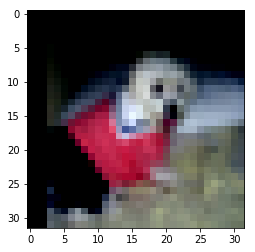

In [30]:
sample = trainset[classindices[5][758]][0]
g = torchvision.utils.make_grid(sample, nrow=1)

g = g / 2 + 0.5     # unnormalize
npimg = g.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [ ]:
def gen_triplet(dataset, classindices, n_samples):
    X = []
    y = []
    for i in range(n_samples):
        c = np.random.choice(10, size=2, replace=False)
        
        p_samples = np.random.choice(classindices[c[0]], size=2, replace=False)
        n_sample = np.random.choice(classindices[c[1]], size=1)
        
        X.append(dataset[p_samples[0]][0])
        X.append(dataset[p_samples[1]][0])
        X.append(dataset[n_sample[0]][0])
        
        y.append(torch.tensor(dataset[p_samples[0]][1], dtype=torch.int32))
        y.append(torch.tensor(dataset[p_samples[1]][1], dtype=torch.int32))
        y.append(torch.tensor(dataset[n_sample[0]][1], dtype=torch.int32))
    
    return (torch.stack(X), 
            torch.stack(y))

In [ ]:
def triplet_loss(loss_fun, output, n_samples, target, reg):
    ix = np.arange(n_samples, dtype=np.int32) * 3
    
    distp = (output[ix] - output[ix + 1]).pow(2).sum(dim=1)
    distn = (output[ix] - output[ix + 2]).pow(2).sum(dim=1)
    
    norm_loss = output.pow(2).sum() / n_samples
    loss_dist = loss_fun(distn, distp, target) / n_samples
    
    return reg * norm_loss + loss_dist

In [ ]:
optimizer = torch.optim.SGD(resnet_embed_cuda.parameters(), lr = 3e-3, momentum=0.9)
lr_update = lambda epoch: 0.95 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_update)

In [ ]:
%%time
reg = 1e-3
margin = 1
loss_fun = nn.MarginRankingLoss(margin=margin)
n_samples = 10

epoch_size = 1000

for e in range(20):
    running_loss = 0.
    scheduler.step()
    
    for i in range(1, epoch_size):
        x, label = gen_triplet(trainset, classindices, n_samples)
        x = x.to(device)
        target = torch.FloatTensor(n_samples).fill_(1).to(device)
        
        optimizer.zero_grad()
        
        out = resnet_embed_cuda.forward(x)
        
        loss = triplet_loss(loss_fun, out, n_samples, target, reg)
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 250 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (e + 1, i, running_loss / 1250))
            running_loss = 0.

In [ ]:
torch.save(resnet_embed_cuda.state_dict(), '/home/yardima/Python/models/cifar10-basic-pretrained/model1-20epoch')

## Test model on kNN classification task

In [22]:
import deeptriplet.models as models

In [23]:
# load model
embed_model = models.CifarResNetEmbed(models.ResNetBasicBlock, [18, 18, 18], embedding_dim=10)
embed_model = nn.DataParallel(embed_model).cuda()
embed_model.load_state_dict(torch.load("/home/yardima/Python/models/cifar10-basic-pretrained/model1"))
embed_model.to(device)
print("Model reloaded\n\n")
embed_model.train(False)

Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBa

/home/yardima/Python/lib/deeptriplet/models/cifar_resnet.py:10: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)



Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Conv2d
BatchNorm2d
Conv2d
BatchNorm2d
Sequential
ResNetBasicBlock
Sequential
Linear
CifarResNetEmbed
Model reloaded




DataParallel(
  (module): CifarResNetEmbed(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): ResNetBasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): ResNetBasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [24]:
trainset = datasets.CIFAR10(root='/scratch/yardima/data/', download=True, train=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=False, num_workers=1)

testset = datasets.CIFAR10(root='/scratch/yardima/data/', download=True, train=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                          shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
%%time
train_embed = []
train_label = []
with torch.autograd.no_grad():
    for x, label in trainloader:
        x = x.to(device)
        y = embed_model.forward(x).cpu().data.numpy().tolist()
        train_embed += y
        train_label += label.numpy().tolist()
        
train_embed = np.array(train_embed)
train_label = np.array(train_label, dtype=np.int32)

CPU times: user 7.96 s, sys: 272 ms, total: 8.24 s
Wall time: 32.4 s


In [26]:
train_embed = train_embed.reshape((-1, list(embed_model.children())[0].EMBED_DIM))

In [27]:
test_embed = []
test_label = []
with torch.autograd.no_grad():
    for x, label in testloader:
        x = x.to(device)
        y = embed_model.forward(x).cpu().data.numpy().tolist()
        test_embed += y
        test_label += label.numpy().tolist()
        
test_embed = np.array(test_embed)
test_label = np.array(test_label, dtype=np.int32)

In [28]:
test_embed = test_embed.reshape((-1, list(embed_model.children())[0].EMBED_DIM))

In [29]:
from sklearn.neighbors import KNeighborsClassifier

nn3_classifier = KNeighborsClassifier(n_neighbors=3, n_jobs=2)

In [30]:
%%time
nn3_classifier.fit(train_embed, train_label)

CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 90.6 ms


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=2, n_neighbors=3, p=2,
           weights='uniform')

In [31]:
%%time
pred3 = nn3_classifier.predict(test_embed)

CPU times: user 1.12 s, sys: 0 ns, total: 1.12 s
Wall time: 1.97 s


In [32]:
print("k-NN classification on MNIST embeddings (k=3)")
print(np.mean(pred3 == test_label))

k-NN classification on MNIST embeddings (k=3)
0.9324
